In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv('movies.csv')
movies.head(5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [3]:
movies.shape

(9742, 3)

In [4]:
def create_missing_df(dataframe):
  
  missing_index = dataframe.columns.tolist() 
  missing = dataframe.isnull().sum().tolist()
  missing_df = pd.DataFrame({'Missing':missing}, index=missing_index)

  return missing_df
create_missing_df(movies)

Missing
movieId        0
title          0
genres         0

In [5]:
def extract_title(title):

  year = title[len(title)-5:len(title)-1]

  if year.isnumeric():
    title_no_year = title[:len(title)-7]
    return title_no_year

  else:
    return title

In [6]:
def extract_year(title):

  year = title[len(title)-5:len(title)-1]

  if year.isnumeric():
    return int(year)

  else:
    return np.nan

In [7]:
movies.rename(columns={'title':'title_year'}, inplace=True) 
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip())
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year) 

In [8]:
create_missing_df(movies)

Missing
movieId           0
title_year        0
genres            0
title             0
year             12

In [9]:
r,c = movies[movies['genres']=='(no genres listed)'].shape 
print('The number of movies which do not have info about genres:',r)

The number of movies which do not have info about genres: 34


In [10]:
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

In [11]:
movies[['title','genres']].head(5)

title                                       genres
0                    Toy Story  Adventure|Animation|Children|Comedy|Fantasy
1                      Jumanji                   Adventure|Children|Fantasy
2             Grumpier Old Men                               Comedy|Romance
3            Waiting to Exhale                         Comedy|Drama|Romance
4  Father of the Bride Part II                                       Comedy

In [12]:
movies['genres'] = movies['genres'].str.replace('|',' ')

C:\Users\SDMITC206013\AppData\Local\Temp\ipykernel_1508\1845334057.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


In [13]:
counts = dict()

for i in movies.index:
  for g in movies.loc[i,'genres'].split(' '):
    if g not in counts:
      counts[g] = 1
    else:
      counts[g] = counts[g] + 1

Text(0, 0.5, 'Counts')

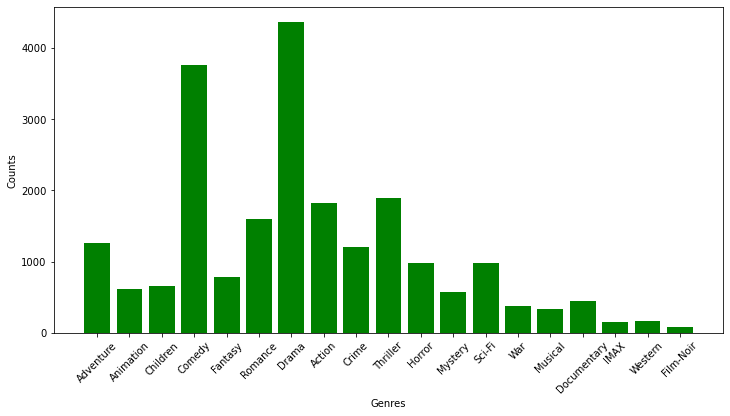

In [14]:
plt.figure(figsize=(12,6))
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
tfidf_vector = TfidfVectorizer(stop_words='english') 
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [17]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


C:\Users\SDMITC206013\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
print(tfidf_matrix[:5])

  (0, 8)	0.48301747178653426
  (0, 4)	0.26738777563975086
  (0, 3)	0.5048957307474672
  (0, 2)	0.5162876752057701
  (0, 1)	0.41680359510322523
  (1, 8)	0.5936766667075072
  (1, 3)	0.6205672299106341
  (1, 1)	0.5122932056626417
  (2, 14)	0.8211549883098352
  (2, 4)	0.5707052524498741
  (3, 7)	0.46621627821471856
  (3, 14)	0.7264518207332316
  (3, 4)	0.5048862585582906
  (4, 4)	1.0


In [19]:
tfidf_matrix.shape
tfidf_matrix.todense()[0]

matrix([[0.        , 0.4168036 , 0.51628768, 0.50489573, 0.26738778,
         0.        , 0.        , 0.        , 0.48301747, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]])

In [20]:
from sklearn.metrics.pairwise import linear_kernel
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix)
print(sim_matrix)

[[1.         0.8136036  0.15259961 ... 0.         0.42114166 0.26738778]
 [0.8136036  1.         0.         ... 0.         0.         0.        ]
 [0.15259961 0.         1.         ... 0.         0.         0.57070525]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.42114166 0.         0.         ... 0.         1.         0.        ]
 [0.26738778 0.         0.57070525 ... 0.         0.         1.        ]]


In [21]:
def get_title_year_from_index(index):

  return movies[movies.index == index]['title_year'].values[0]

def get_index_from_title(title):

  return movies[movies.title == title].index.values[0]

In [22]:
!pip install fuzzywuzzy

In [28]:
from fuzzywuzzy import fuzz

C:\Users\SDMITC206013\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [23]:
def matching_score(a,b):

  return fuzz.ratio(a,b)

In [24]:
def get_title_from_index(index):

  return movies[movies.index == index]['title'].values[0]

In [25]:
def find_closest_title(title):

  leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
  sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
  closest_title = get_title_from_index(sorted_leven_scores[0][0])
  distance_score = sorted_leven_scores[0][1]

  return closest_title, distance_score

In [26]:
def contents_based_recommender(movie_user_likes, how_many):

  closest_title, distance_score = find_closest_title(movie_user_likes)

  if distance_score == 100:

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) # remove the typed movie itself

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]: 
      print(get_title_year_from_index(i))
    

  else:
    print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')

    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))

    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    for i,s in similar_movies[:how_many]:
      print(get_title_year_from_index(i))

In [29]:
contents_based_recommender('Monsters, Inc.', 20)

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Wild, The (2006)
Shrek the Third (2007)
Tale of Despereaux, The (2008)
Asterix and the Vikings (Astérix et les Vikings) (2006)
Turbo (2013)
The Good Dinosaur (2015)
Moana (2016)
Inside Out (2015)
Black Cauldron, The (1985)
Lord of the Rings, The (1978)
We're Back! A Dinosaur's Story (1993)
Atlantis: The Lost Empire (2001)
Land Before Time, The (1988)
Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)
Sinbad: Legend of the Seven Seas (2003)


In [31]:
contents_based_recommender('Jury Duty', 20)

Here's the list of movies similar to Jury Duty.

Father of the Bride Part II (1995)
Four Rooms (1995)
Ace Ventura: When Nature Calls (1995)
Bio-Dome (1996)
Friday (1995)
Black Sheep (1996)
Mr. Wrong (1996)
Happy Gilmore (1996)
Steal Big, Steal Little (1995)
Flirting With Disaster (1996)
Down Periscope (1996)
Birdcage, The (1996)
Brothers McMullen, The (1995)
Living in Oblivion (1995)
Party Girl (1995)
To Wong Foo, Thanks for Everything! Julie Newmar (1995)
Billy Madison (1995)
Clerks (1994)
Destiny Turns on the Radio (1995)
Exit to Eden (1994)
